In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


/kaggle/input/store-sales-time-series-forecasting/oil.csv
/kaggle/input/store-sales-time-series-forecasting/sample_submission.csv
/kaggle/input/store-sales-time-series-forecasting/holidays_events.csv
/kaggle/input/store-sales-time-series-forecasting/stores.csv
/kaggle/input/store-sales-time-series-forecasting/train.csv
/kaggle/input/store-sales-time-series-forecasting/test.csv
/kaggle/input/store-sales-time-series-forecasting/transactions.csv


# Momento de Retroalimentación: Reto Limpieza del Conjunto de Datos

## Predicciones de venta para las tiendas Favorita

Documento de análisis: https://docs.google.com/document/d/1WZNxJ-wSE6K8wZKmX6lFai6Z2BT1WmAgjC3g8u6PCs0/edit

Presentación de avance: https://docs.google.com/presentation/d/1VzJBf_ssgdRzuZ6XmWEBgiDqbYzE2eqXWB2ucQNZnp8/edit#slide=id.g608d0fa1da_0_8133

### Equipo:

***- Fermín Méndez García A01703366***

***- Emiliano Vásquez Olea A01707035***

***- Diego Emilio Barrera  A01366802***

***- Karen Cebreros López A01704254***

In [2]:
DATA_PATH = '../input/store-sales-time-series-forecasting'

# Carga de datos

df_train = pd.read_csv(os.path.join(DATA_PATH, 'train.csv'))
df_test = pd.read_csv(os.path.join(DATA_PATH, 'test.csv'))
df_stores = pd.read_csv(os.path.join(DATA_PATH, 'stores.csv'))
df_transactions = pd.read_csv(os.path.join(DATA_PATH, 'transactions.csv'))
df_oil = pd.read_csv(os.path.join(DATA_PATH, 'oil.csv'))
df_holidays = pd.read_csv(os.path.join(DATA_PATH, 'holidays_events.csv'))

In [3]:
df_stores.describe()

,store_nbr,cluster
count,54.000000,54.000000
mean,27.500000,8.481481
std,15.732133,4.693395
min,1.000000,1.000000
25%,14.250000,4.000000
50%,27.500000,8.500000
75%,40.750000,13.000000
max,54.000000,17.000000


## Identificar valores faltantes

In [4]:
df_oil.isna().sum()

date           0
dcoilwtico    43
dtype: int64

In [5]:
# Llenar datos faltantes del precio del petróleo con el valor del dia posterior
df_oil.fillna(method='bfill', inplace = True)

In [6]:
df_oil.isna().sum()

date          0
dcoilwtico    0
dtype: int64

Los datos faltantes en los dataset ya fueron llenados, ahora podemos eliminar aquellos registros que no son indicativos de las ventas actuales.

En este caso eliminamos registros sin ventas de ciertas tiendas, indicando posiblemente una falta de información o que las sucursales no habían sido abiertas.

In [7]:
df_train = df_train[~((df_train.store_nbr == 52) & (df_train.date < '2017-04-20'))]
df_train = df_train[~((df_train.store_nbr == 22) & (df_train.date < '2015-10-09'))]
df_train = df_train[~((df_train.store_nbr == 42) & (df_train.date < '2015-08-21'))]
df_train = df_train[~((df_train.store_nbr == 21) & (df_train.date < '2015-07-24'))]
df_train = df_train[~((df_train.store_nbr == 29) & (df_train.date < '2015-03-20'))]
df_train = df_train[~((df_train.store_nbr == 20) & (df_train.date < '2015-02-13'))]
df_train = df_train[~((df_train.store_nbr == 53) & (df_train.date < '2014-05-29'))]
df_train = df_train[~((df_train.store_nbr == 36) & (df_train.date < '2013-05-09'))]

## Análisis de datos principales de entrenamiento

In [8]:
df_train

,id,date,store_nbr,family,sales,onpromotion
0,0,2013-01-01,1,AUTOMOTIVE,0.000,0
1,1,2013-01-01,1,BABY CARE,0.000,0
2,2,2013-01-01,1,BEAUTY,0.000,0
3,3,2013-01-01,1,BEVERAGES,0.000,0
4,4,2013-01-01,1,BOOKS,0.000,0
...,...,...,...,...,...,...
3000883,3000883,2017-08-15,9,POULTRY,438.133,0
3000884,3000884,2017-08-15,9,PREPARED FOODS,154.553,1
3000885,3000885,2017-08-15,9,PRODUCE,2419.729,148
3000886,3000886,2017-08-15,9,SCHOOL AND OFFICE SUPPLIES,121.000,8


In [9]:
df_train.describe()

,id,store_nbr,sales,onpromotion
count,2.780316e+06,2.780316e+06,2.780316e+06,2.780316e+06
mean,1.547738e+06,2.690357e+01,3.861593e+02,2.809257e+00
std,8.648191e+05,1.558373e+01,1.140079e+03,1.267145e+01
min,0.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00
25%,8.034178e+05,1.300000e+01,0.000000e+00,0.000000e+00
50%,1.580370e+06,2.700000e+01,1.600000e+01,0.000000e+00
75%,2.296634e+06,4.000000e+01,2.270000e+02,0.000000e+00
max,3.000887e+06,5.400000e+01,1.247170e+05,7.410000e+02


Eliminamos la columna de id, ya que es un identificador único

In [10]:
df_train.drop(['id'], axis = 1, inplace = True)

Aplicamos One Hot Encoding sobre los datos de entrenamiento para representar los valores categóricos de la columna "family" de forma numérica.

In [11]:
encoded_family_df = pd.get_dummies(df_train['family'], prefix='family')
df_train_encoded = pd.concat([df_train, encoded_family_df], axis = 1).drop(['family'], axis = 1)

In [12]:
df_train_encoded

,date,store_nbr,sales,onpromotion,family_AUTOMOTIVE,family_BABY CARE,family_BEAUTY,family_BEVERAGES,family_BOOKS,family_BREAD/BAKERY,...,family_MAGAZINES,family_MEATS,family_PERSONAL CARE,family_PET SUPPLIES,family_PLAYERS AND ELECTRONICS,family_POULTRY,family_PREPARED FOODS,family_PRODUCE,family_SCHOOL AND OFFICE SUPPLIES,family_SEAFOOD
0,2013-01-01,1,0.000,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,2013-01-01,1,0.000,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,2013-01-01,1,0.000,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,2013-01-01,1,0.000,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
4,2013-01-01,1,0.000,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3000883,2017-08-15,9,438.133,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
3000884,2017-08-15,9,154.553,1,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
3000885,2017-08-15,9,2419.729,148,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
3000886,2017-08-15,9,121.000,8,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0


/tmp/ipykernel_32/2372759694.py:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  correlation_matrix = df_train.corr()


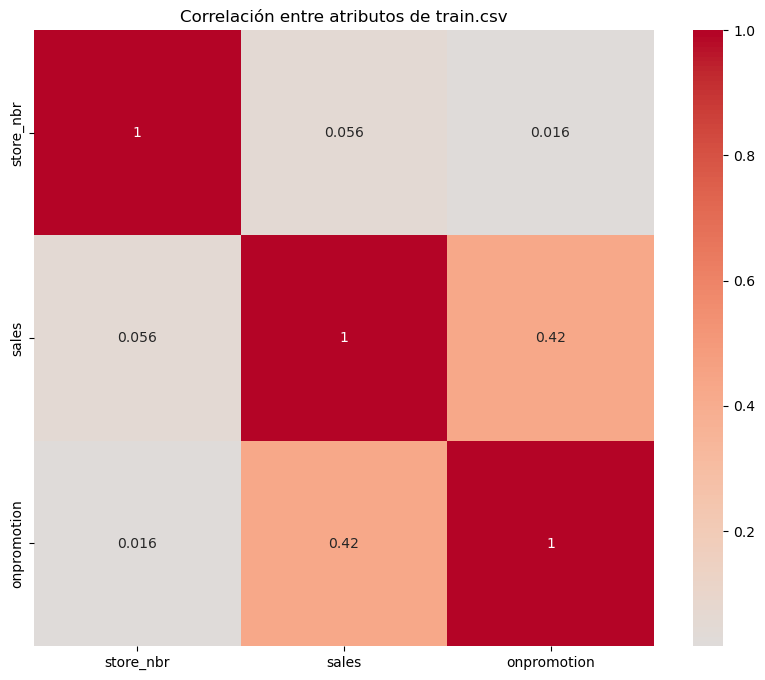

In [13]:
correlation_matrix = df_train.corr()

# Set up the heatmap figure
plt.figure(figsize = (10, 8))

# Create heatmap using seaborn
sns.heatmap(correlation_matrix, annot = True, cmap = "coolwarm", center = 0)

# Show the plot
plt.title("Correlación entre atributos de train.csv")
plt.show()

Promedio de ventas por todas las tiendas en un día.

In [14]:
average_sales = df_train.groupby('date')['sales'].mean()
average_sales_df = average_sales.reset_index()

Gráfico de datos y marcar tendencia a lo largo de los años

In [15]:
px.scatter(x = pd.to_datetime(average_sales_df["date"]), y = average_sales_df["sales"], trendline="ols", trendline_color_override = 'red')

Es posible que algunos de los valores extremos se deban a situaciones especiales, como el terremoto de gran magnitud del 2016 en Ecuador.

In [16]:
average_sales_by_family = df_train.groupby('family')['sales'].mean()

## Análisis del precio del petróleo

El petroleo es un factor que refleja la economía de Ecuador, al ser un país petrolero. Este es uno de los indicadores externos que puede afectar las ventas de las tiendas Favorita, por lo que es importante tomarlo en cuenta.

In [17]:
df_oil.describe()

,dcoilwtico
count,1218.000000
mean,67.673325
std,25.637345
min,26.190000
25%,46.422500
50%,53.185000
75%,95.595000
max,110.620000


En estos datos vemos un valor mínimo de 26 y un máximo de 110, mostrando una gran variabilidad entre años. Este máximo es más de cuatro veces el valor mínimo.

<Axes: xlabel='date', ylabel='dcoilwtico'>

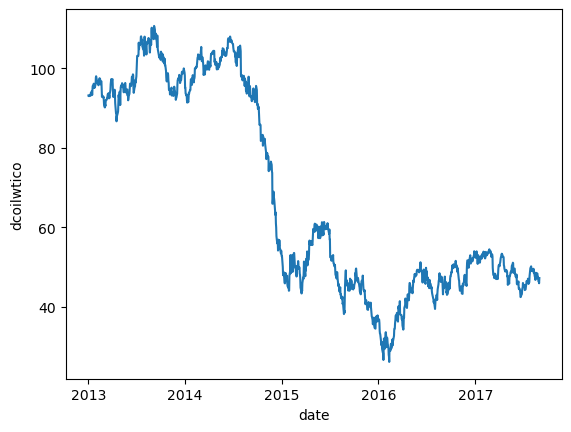

In [18]:
sns.lineplot(df_oil, x = pd.to_datetime(df_oil["date"]), y = df_oil["dcoilwtico"])

## Análisis de transacciones

In [19]:
df_transactions

,date,store_nbr,transactions
0,2013-01-01,25,770
1,2013-01-02,1,2111
2,2013-01-02,2,2358
3,2013-01-02,3,3487
4,2013-01-02,4,1922
...,...,...,...
83483,2017-08-15,50,2804
83484,2017-08-15,51,1573
83485,2017-08-15,52,2255
83486,2017-08-15,53,932


Promedio de transacciones en un día

In [20]:
average_transactions = df_transactions.groupby('date')['transactions'].mean()
average_transactions_df = average_transactions.reset_index()

In [21]:
px.scatter(x = pd.to_datetime(average_transactions_df["date"]), y = average_transactions_df["transactions"], trendline="ols", trendline_color_override = 'red')

# Análisis por estaciones

In [22]:
from learntools.time_series.utils import plot_periodogram, seasonal_plot

Identificar los periodos de tiempo donde existen patrones fuertes en el comportamiento.

/opt/conda/lib/python3.10/site-packages/learntools/time_series/utils.py:43: FutureWarning:

Units 'M', 'Y' and 'y' do not represent unambiguous timedelta values and will be removed in a future version.



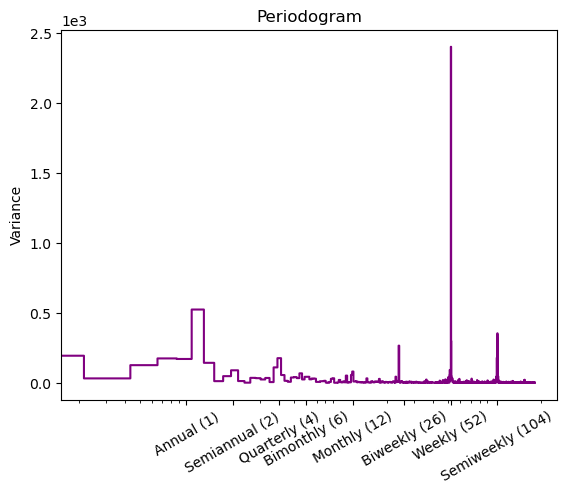

In [23]:
plot_periodogram(average_sales);

In [24]:
store_sales = pd.read_csv(
    os.path.join(DATA_PATH, 'train.csv'),
    usecols=['store_nbr', 'family', 'date', 'sales'],
    dtype={
        'store_nbr': 'category',
        'family': 'category',
        'sales': 'float32',
    },
    parse_dates=['date'],
    infer_datetime_format=True,
)
store_sales['date'] = store_sales.date.dt.to_period('D')
store_sales = store_sales.set_index(['store_nbr', 'family', 'date']).sort_index()
average_sales = (
    store_sales
    .groupby('date').mean()
    .squeeze()
    .loc['2017']
)

Promedio de ventas por dia en cada tienda en el año 2017

/opt/conda/lib/python3.10/site-packages/learntools/time_series/utils.py:15: FutureWarning:



The `ci` parameter is deprecated. Use `errorbar=('ci', False)` for the same effect.




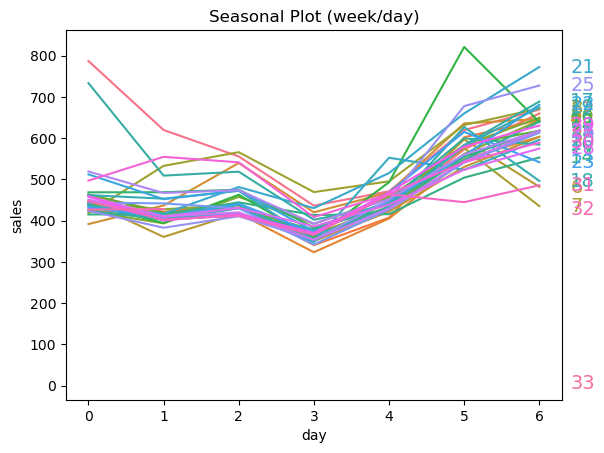

In [25]:
X = average_sales.to_frame()
X["week"] = X.index.week
X["day"] = X.index.dayofweek
seasonal_plot(X, y='sales', period='week', freq='day');